In [1]:
import ast
import sys
from pathlib import Path

import h5py as h5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns

sys.path.append('../lib')
from local_paths import mplstyle_path, analysis_dir, database_dir
from stats_utils import fdr_correction, corr_perm_test, p2str
from summary_utils import annotate_unit_df, select_units

In [2]:
plt.style.use(mplstyle_path)

# Parameters

In [3]:
analysis_name = 'face_specific'
results_dir = analysis_dir + analysis_name

# unit selection
unit_sel_path = database_dir + 'unit_sel/visually_selective.csv.gz'
array_selection = (  # face-patch arrays
    ('Pa', 1), ('Pa', 2),  # M1 (CIT)
    ('Bo', 3),  # M2 (AIT)
    ('Re', 6))  # M3 (AIT)
fsi_thres = 0.2

# statistics
fsi_test = ('Fixation 1+', 'Fixation 0', 'two-sided')
fdr_level = 0.01

# Load data

In [4]:
unit_df = {'Session': [], 'Unit': []}
results = {k: [] for k in ('fsi0', 'fsi1', 'fsi_pvals')}

results_dir = Path(results_dir).expanduser()
for fp in results_dir.glob('*.h5'):
    with h5.File(fp, 'r') as f:
        try:
            assert f[f'progress_report/{analysis_name}/all_done'][()]
            dset = f[analysis_name+'/by_fixation/face_selectivity']
        except (KeyError, AssertionError):
            continue

        fsi0, fsi1 = dset['face_selectivity_index'][()]
        unit_names = dset['unit'][()].astype(str)

        tests = [ast.literal_eval(''.join(v)) for v in dset['two_sample_test'][()].astype(str)]
        pvals = dset['two-sample_p-value'][tests.index(fsi_test)]

    results['fsi0'].append(fsi0)
    results['fsi1'].append(fsi1)
    results['fsi_pvals'].append(pvals)
    unit_df['Session'].append(np.full(unit_names.size, fp.stem))
    unit_df['Unit'].append(unit_names)

print('results:')
for d in (results, unit_df):
    for k, v in d.items():
        d[k] = v = np.concatenate(v, axis=-1)
        print('\t', f'{k:<15s}', v.shape, '\t', v.dtype)
print(np.unique(unit_df['Session']).size, 'sessions')
unit_df = annotate_unit_df(pd.DataFrame(unit_df))

results:
	 fsi0            (13264,) 	 float32
	 fsi1            (13264,) 	 float32
	 fsi_pvals       (13264,) 	 float64
	 Session         (13264,) 	 <U10
	 Unit            (13264,) 	 <U3
128 sessions


# Select units

In [5]:
result_vals = np.array([
    results['fsi0'],
    results['fsi1'],
    results['fsi_pvals']])
del results

In [6]:
m = result_vals[:2]
m = np.isfinite(m).all(0) & (m != -1).all(0)

unit_df, unit_sel, regions = select_units(
    unit_df,
    selection_path=unit_sel_path,
    select_valid_values=m)

result_vals = result_vals[...,unit_sel]
unit_df.reset_index()[['Session','Unit']].to_csv('unit_sel/fig2b.csv.gz', index=False)

> Selected units: n = 6693 of 13264 (50.5% of data, 24.8% of selection) based on visually_selective.csv.gz
> Selected units: n = 6312 of 6693 (94.3%) with valid values
> No rare subject to exclude
	 min norm. units per region: Region
	AIT    0.855561
	CIT    1.000000
	Name: Norm. units, dtype: float64


Save face-selective units for other analyses

In [7]:
mfs = result_vals[0] >= fsi_thres
print(f'{mfs.sum()} of {mfs.size} units ({mfs.mean()*100:.1f}%) passed threshold FSI >= {fsi_thres}')
unit_df[mfs].reset_index()[['Session','Unit']].to_csv('unit_sel/face_selective.csv.gz', index=False)

2683 of 6312 units (42.5%) passed threshold FSI >= 0.2


# Compare FSI between zeroth and non-zeroth fixations

In [8]:
fsi_arej = fdr_correction({None: result_vals[2]}, q=fdr_level)[0][None]
m_ = result_vals[1] > result_vals[0]

for i in range(3):
    if i < 2:
        m0 = mfs ^ bool(i)
        print('FSI 0', ('>=', '<')[i], fsi_thres)
    else:
        m0 = np.ones_like(mfs)
        print('Overall')

    for j in range(2):
        m1 = (fsi_arej ^ bool(j)) & m0
        if not j:
            m2s = [(('>','<')[k], m1 & (m_ ^ bool(k))) for k in range(2)]
        else:
            m2s = [('≈', m1)]
        for s, m2 in m2s:
            print(f'FSI 1+ {s} FSI 0:\tn = {m2.sum():>4d}, {m2.sum()/m0.sum()*100:4.1f}%, {m2.mean()*100:4.1f}% overall')
    if i < 2: print()

FSI 0 >= 0.2
FSI 1+ > FSI 0:	n =   34,  1.3%,  0.5% overall
FSI 1+ < FSI 0:	n =    5,  0.2%,  0.1% overall
FSI 1+ ≈ FSI 0:	n = 2644, 98.5%, 41.9% overall

FSI 0 < 0.2
FSI 1+ > FSI 0:	n =   57,  1.6%,  0.9% overall
FSI 1+ < FSI 0:	n =   12,  0.3%,  0.2% overall
FSI 1+ ≈ FSI 0:	n = 3560, 98.1%, 56.4% overall

Overall
FSI 1+ > FSI 0:	n =   91,  1.4%,  1.4% overall
FSI 1+ < FSI 0:	n =   17,  0.3%,  0.3% overall
FSI 1+ ≈ FSI 0:	n = 6204, 98.3%, 98.3% overall


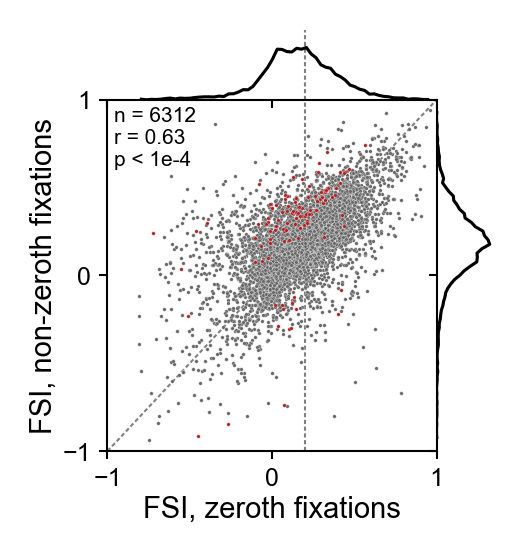

In [9]:
data = pd.DataFrame(data=result_vals[:2].T, columns=('fsi0','fsi1'))

# set up joint grid
jg = sns.JointGrid(
    data=data, x='fsi0', y='fsi1',
    height=1.85, xlim=(-1,1), ylim=(-1,1), space=0)
jg.fig.set_dpi(300)

# plot marginals
jg.plot_marginals(
    sns.histplot, common_norm=False, element='poly',
    color='k', lw=0.75, fill=False)

# plot scatter, color by category based on stat tests
m = fsi_arej
kw = dict(x='fsi0', y='fsi1', s=.75, ax=jg.ax_joint)
sns.scatterplot(data=data[~m], fc='dimgray', **kw)
sns.scatterplot(data=data[m], fc='firebrick', **kw)

# stats
x = data['fsi0'].values
y = data['fsi1'].values
r = st.pearsonr(x, y)[0]
p = corr_perm_test(x, y)

# format plot
kw = dict(ls='--', lw=.5, color='gray', zorder=-1)
jg.refline(x=0.2, **kw)
ax = jg.ax_joint
ax.plot([-1,1], [-1,1], **kw)

ax.set_xticks([-1, 0, 1])
ax.spines['bottom'].set_bounds([-1,1])
ax.set_xlabel('FSI, zeroth fixations')

ax.set_yticks([-1, 0, 1])
ax.spines['left'].set_bounds([-1,1])
ax.set_ylabel('FSI, non-zeroth fixations')

ax.text(
    .02, .98, f'n = {len(data)}\nr = {r:.2f}\np {p2str(p, return_cmp=True)}',
    fontsize=5, ha='left', va='top', transform=ax.transAxes)

plt.savefig('plots/fig2b.png')